<a href="https://colab.research.google.com/github/lacykaltgr/quant/blob/main/quant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Setup

In [2]:
import pandas as pd
import numpy as np

In [3]:
quant_folder_location = "/content/drive/MyDrive/quant"
weather_prepared_file_path = quant_folder_location + "/weather_df.csv"
county_location_file_path = quant_folder_location + "/agri/minnesota_county_location.csv"
county_agr_prod_file_path = quant_folder_location + "/agri/minnesota_county_yearly_agricultural_production.csv"
station_location_file_path = quant_folder_location + "/weather/minnesota_station_location.csv"

def station_weather_fp(station_name):
  return quant_folder_location + "/weather/minnesota_daily/" + str(station_name) + ".csv"

# Prepare weather data


In [4]:
#átugrási lehetőség
weather_df = pd.read_csv(weather_prepared_file_path)

<ipython-input-4-b90705cc2f0b>:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_df = pd.read_csv(weather_prepared_file_path)


In [7]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603227 entries, 0 to 603226
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  603227 non-null  int64  
 1   date        603227 non-null  object 
 2   avg         603227 non-null  float64
 3   min         603227 non-null  float64
 4   max         603227 non-null  float64
 5   rain        603227 non-null  float64
 6   code        603227 non-null  object 
 7   lat         603227 non-null  float64
 8   lon         603227 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 41.4+ MB


In [6]:
station_location_df = pd.read_csv(station_location_file_path)
station_weather_df_list = []
station_codes = np.unique(station_location_df.Code)
for code in station_codes:
  try:
      station_df = pd.read_csv(station_weather_fp(code), header=None, index_col=False, names=["date", "avg", "min", "max", "rain"])
      station_weather_df_list.append(station_df)
  except:
      station_codes.remove(code)
      print(f"Hibás/üres fájl: {code}")

In [16]:
from dateutil.relativedelta import relativedelta
import math

for station in station_weather_df_list:
  station["date"] = pd.to_datetime(station["date"])
  station["min"] = station["min"].interpolate(method="linear", limit=21)
  station["max"] = station["max"].interpolate(method="linear", limit=21)
  for index, record in station.iterrows():
    if math.isnan(record["min"]):
      for i in range(index, index+10*365+1, 365):
        if not math.isnan(station.iloc[i+365]["min"]):
          station.loc[index, "min"] = station.iloc[i+365]["min"]
          break
        else: 
          if not math.isnan(station.iloc[i-365]["min"]):
            station.loc[index, "min"] = station.iloc[i-365]["min"]
            break
    if math.isnan(record["max"]):
      for i in range(index, index+15*365+1, 365):
        if not math.isnan(station.iloc[i+365]["max"]):
          station.loc[index, "max"] = station.iloc[i+365]["max"]
          break
        else:
          if not math.isnan(station.iloc[i-365]["max"]):
            station.loc[index, "max"] = station.iloc[i-365]["max"]
            break
    if math.isnan(record["rain"]):
      i = index+365
      while i < len(station):
        if not math.isnan(station.iloc[i]["rain"]):
          station.loc[index, "rain"] = station.iloc[i]["rain"]
          break
        i += 365

KeyboardInterrupt: ignored

In [ ]:
for i, (station_data, code) in enumerate(zip(station_weather_df_list, station_codes)):
  lat = station_location_df[station_location_df["Code"] == code ].Latitude.values[0]
  lon = station_location_df[station_location_df["Code"] == code ].Longitude.values[0]
  station_weather_df_list[i] = station_data.assign(code = code, lat = lat, lon = lon)

combined_weather_df = pd.concat(station_weather_df_list, axis=0)

In [ ]:
combined_weather_df["rain"] = combined_weather_df["rain"].fillna(0)

In [ ]:
combined_weather_df.info()

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor

no_missing_weather_df = combined_weather_df[combined_weather_df["avg"].notnull()]
no_missing_weather_train_df = no_missing_weather_df.drop(["code", "rain"], axis=1)
no_missing_weather_train_df['year'] = no_missing_weather_train_df['date'].dt.year
no_missing_weather_train_df['month'] = no_missing_weather_train_df['date'].dt.month
no_missing_weather_train_df['day'] = no_missing_weather_train_df['date'].dt.day
no_missing_weather_train_df = no_missing_weather_train_df.drop("date", axis=1)

X_fill_avg = no_missing_weather_train_df.drop("avg", axis=1)
y_fill_avg = no_missing_weather_train_df["avg"]
X_avg_train, X_avg_test, y_avg_train, y_avg_test = train_test_split(X_fill_avg, y_fill_avg, test_size=0.1)
evaluation = [(X_avg_train, y_avg_train), (X_avg_test, y_avg_test)]

model = XGBRegressor(early_stopping_rounds=300)
model.fit(X_avg_train, y_avg_train, eval_set=evaluation, verbose=1)

In [ ]:
missing_avg_weather_df = combined_weather_df[combined_weather_df["avg"].isnull()]
missing_avg_weather_prediction_X_df = missing_avg_weather_df.drop(["avg", "code", "rain"], axis=1)
missing_avg_weather_prediction_X_df['year'] = missing_avg_weather_prediction_X_df['date'].dt.year
missing_avg_weather_prediction_X_df['month'] = missing_avg_weather_prediction_X_df['date'].dt.month
missing_avg_weather_prediction_X_df['day'] = missing_avg_weather_prediction_X_df['date'].dt.day
missing_avg_weather_prediction_X_df = missing_avg_weather_prediction_X_df.drop("date", axis=1)

missing_avg_weather_prediction_y_df = model.predict(missing_avg_weather_prediction_X_df)
missing_avg_weather_df["avg"] = missing_avg_weather_prediction_y_df

In [ ]:
missing_avg_weather_df.info()

In [ ]:
weather_df = pd.concat([missing_avg_weather_df, no_missing_weather_df], axis=0)

In [21]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603227 entries, 0 to 603226
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  603227 non-null  int64  
 1   date        603227 non-null  object 
 2   avg         603227 non-null  float64
 3   min         603227 non-null  float64
 4   max         603227 non-null  float64
 5   rain        603227 non-null  float64
 6   code        603227 non-null  object 
 7   lat         603227 non-null  float64
 8   lon         603227 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 41.4+ MB


In [6]:
filename = 'weather_df.csv'
weather_df.to_csv('/content/drive/MyDrive/quant' + filename)

In [34]:
#normalizálás
from sklearn.preprocessing import MinMaxScaler

avg_scaler = MinMaxScaler()
min_scaler = MinMaxScaler()
max_scaler = MinMaxScaler()
rain_scaler = MinMaxScaler()

weather_df["avg"] = avg_scaler.fit_transform(weather_df["avg"])
weather_df["min"] = min_scaler.fit_transform(weather_df["min"])
weather_df["max"] = max_scaler.fit_transform(weather_df["max"])
weather_df["rain"] = rain_scaler.fit_transform(weather_df["rain"])

ValueError: ignored

In [31]:
weather_stations = []
for code in station_codes:
  station = dict()
  station["code"] = code
  station["lat"] = station_location_df[station_location_df["Code"] == code]["Latitude"].values[0]
  station["lon"] = station_location_df[station_location_df["Code"] == code]["Longitude"].values[0]

  weather_data = weather_df[weather_df['code'] == code].drop(["code", "Unnamed: 0", "lat", "lon"], axis=1)
  station["weather_daily"] = weather_data

  weather_data["date"] = pd.to_datetime(weather_data["date"])
  weather_data["year"] = weather_data['date'].dt.year
  weather_data['week'] = weather_data['date'].dt.isocalendar().week
  weather_data = weather_data.drop("date", axis=1)
  weekly_stats = weather_data.groupby(['year', 'week']).agg({'min': ['mean', 'std'], 'max': ['mean', 'std'], 'avg': ['mean', 'std'], 'rain': ['mean', 'std']})
  weekly_stats = weekly_stats.reset_index()
  weekly_stats.columns = ['year', 'week', 'min_mean', 'min_std', 'max_mean', 'max_std', 'avg_mean', 'avg_std', 'rain_mean', 'rain_std']
  weekly_stats = weekly_stats.fillna(0)
  weekly_stats.set_index('week',inplace=True)

  for i in range(1, 52+1):
    if not (weekly_stats.index == i).any():
      if i == 1:
        weekly_stats.loc[i] = 0
      else:
        weekly_stats.loc[i] = weekly_stats.loc[i-1]
  station["weather_weekly"] = weekly_stats
  weather_stations.append(station)
len(weather_stations)

97

In [32]:
weather_stations[0]["weather_weekly"].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2588 entries, 1 to 52
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   year       2588 non-null   int64  
 1   min_mean   2588 non-null   float64
 2   min_std    2588 non-null   float64
 3   max_mean   2588 non-null   float64
 4   max_std    2588 non-null   float64
 5   avg_mean   2588 non-null   float64
 6   avg_std    2588 non-null   float64
 7   rain_mean  2588 non-null   float64
 8   rain_std   2588 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 194.6 KB


# Prepare crop data

In [33]:
county_locations_df = pd.read_csv(county_location_file_path)
county_agr_prod_df = pd.read_csv(county_agr_prod_file_path, decimal=',')

In [9]:
county_agr_prod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56268 entries, 0 to 56267
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Year                          56268 non-null  int64 
 1   County                        56268 non-null  object
 2   Commodity                     56268 non-null  object
 3   Crop                          56268 non-null  object
 4   ACRES HARVESTED               52674 non-null  object
 5   PRODUCTION, MEASURED IN BU    33231 non-null  object
 6   YIELD, MEASURED IN BU / ACRE  33232 non-null  object
dtypes: int64(1), object(6)
memory usage: 3.0+ MB


In [9]:
county_agr_prod_df = county_agr_prod_df.rename(
    columns={'ACRES HARVESTED': 'acres', 
             'PRODUCTION, MEASURED IN BU': 'production', 
             'YIELD, MEASURED IN BU / ACRE': 'yield'})
county_agr_prod_df['acres'] = pd.to_numeric(county_agr_prod_df['acres'].astype(str).str.replace(',', '.'), errors='coerce')
county_agr_prod_df['production'] = pd.to_numeric(county_agr_prod_df['production'].astype(str).str.replace(',', '.'), errors='coerce')
county_agr_prod_df['yield'] = pd.to_numeric(county_agr_prod_df['yield'].astype(str).str.replace(',', '.'), errors='coerce')
county_agr_prod_df = county_agr_prod_df[county_agr_prod_df['acres'].notnull() | county_agr_prod_df['production'].notnull() | county_agr_prod_df['yield'].notnull()]

corn_df = county_agr_prod_df[county_agr_prod_df["Crop"] == "CORN, GRAIN"] #| county_agr_prod_df["Crop"] == "CORN, SILAGE"]
oat_df = county_agr_prod_df[county_agr_prod_df["Crop"] == "OATS"]
soybean_df = county_agr_prod_df[county_agr_prod_df["Crop"] == "SOYBEANS"]

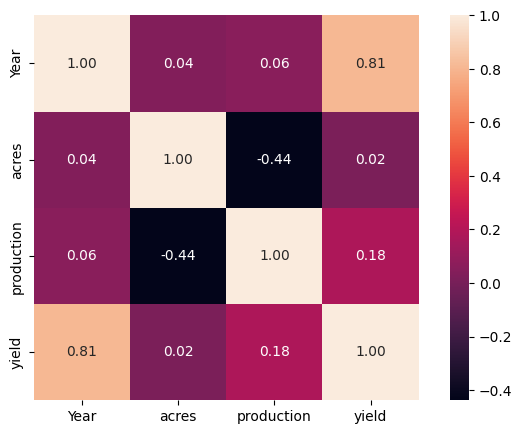

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plot = corn_df

plot = plot[plot['acres'].notnull() & plot['production'].notnull() & plot['yield'].notnull()]
numeric_columns = plot.select_dtypes(include=['int64', 'float64']).columns

cm = np.corrcoef(plot[numeric_columns].values.T)
fig = plt.gcf()
fig.set_size_inches(8, 5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=numeric_columns.values, xticklabels=numeric_columns.values)

In [11]:
county_locations_df['county_name'] = county_locations_df['county_name'].apply(lambda x: ' '.join(x.split()[:-1]).upper())
county_locations_df['county_name'] = county_locations_df['county_name'].str.replace('SAINT LOUIS', 'ST. LOUIS')
corn_df_extended = pd.merge(corn_df, county_locations_df, how='outer', left_on='County', right_on='county_name')

In [12]:
corn_df_clean = corn_df_extended.drop(["County", "Commodity", "Crop", "county_name", "capital_name", "production", "acres"], axis=1)
corn_df_clean = corn_df_clean[corn_df_clean["yield"].notnull() & corn_df_clean["county_latitude"].notnull() & corn_df_clean["county_longitude"].notnull()]

#Putting it all together...

In [13]:
corn_df_clean.info() #corn clean df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5014 entries, 0 to 5014
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              5014 non-null   float64
 1   yield             5014 non-null   float64
 2   county_latitude   5014 non-null   float64
 3   county_longitude  5014 non-null   float64
dtypes: float64(4)
memory usage: 195.9 KB


In [14]:
from math import radians, sin, cos, sqrt, atan2

def distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km

    # Convert latitude and longitude to radians
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    # Calculate the differences between the two points
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Calculate the haversine of half the differences
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2

    # Calculate the great circle distance
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    # Calculate the distance in kilometers
    dist = R * c

    return dist


def distance_from_station(weather_station, lat, lon):
  return distance(weather_station["lat"], weather_station["lon"], lat, lon)


In [15]:
weather_staions = filter(lambda x: not x["weather_weekly"].empty, weather_stations)

In [16]:
data = []
for _, y in corn_df_clean.iterrows():
  yearly_data = dict()
  yearly_data["year"] = y["Year"]
  yearly_data["yield"] = y["yield"]
  county_lat = y["county_latitude"]
  county_lon = y["county_longitude"]
  stations = sorted(weather_stations, key=lambda s:distance_from_station(s, county_lat, county_lon))

  i = 0
  while distance_from_station(stations[i], county_lat, county_lon) < 120:
    station_weekly = stations[i]["weather_weekly"]
    yearly_data["weather"] = station_weekly[station_weekly["year"] == y["Year"]]
    yearly_data["weather"] = yearly_data["weather"].drop(["year", "week"], axis=1)
    if not yearly_data['weather'].empty:
      data.append(yearly_data)
      break
    i += 1
  
len(data)

2860

In [20]:
#valid_adatok = []
#for tav in range(10, 200, 5):
#  data = []
#  for _, y in corn_df_clean.iterrows():
#    yearly_data = dict()
#    yearly_data["year"] = y["Year"]
#    yearly_data["yield"] = y["yield"]
#    county_lat = y["county_latitude"]
#    county_lon = y["county_longitude"]
#    stations = sorted(weather_stations, key=lambda s:distance_from_station(s, county_lat, county_lon))
#
#    i = 0
#    while distance_from_station(stations[i], county_lat, county_lon) < tav:
#      station_weekly = stations[i]["weather_weekly"]
#      yearly_data["weather"] = station_weekly[station_weekly["year"] == y["Year"]]
#      if not yearly_data['weather'].empty:
#        data.append(yearly_data)
#        break
#      i += 1
    
#  valid_adatok.append(len(data))

In [ ]:
#import matplotlib.pyplot as plt
#x_values = [10+x*5 for x in range(len(valid_adatok))]
#plt.xticks(range(len(valid_adatok)), x_values, rotation=90)
#plt.plot(valid_adatok)

In [17]:
data = list(filter(lambda x: x["weather"].to_numpy().shape[0] > 26, data))
len(data)

2742

In [81]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

seq_len = 52
num_features = 8

X_weather = []
for sample in data:
    weather_data = sample["weather"].to_numpy()
    X_weather.append(weather_data)
X_weather = pad_sequences(X_weather, maxlen=52, padding='post', truncating='post', dtype='float32')

X_year = np.array(list(map(lambda s: s["year"], data)))
y = np.array(list(map(lambda s: s["yield"], data)))

In [82]:
from sklearn.preprocessing import MinMaxScaler

split_ratio = 0.9
split = int(len(data)*split_ratio)

X_weather_train = np.stack(X_weather[:split])
X_weather_val = np.stack(X_weather[split:])
X_year_train = X_year[:split]
X_year_val = X_year[split:]
y_train = y[:split]
y_val = y[split:]

#scaler = MinMaxScaler()
#X_weather_train = scaler.fit_transform(X_weather_train)
#X_weather_val = scaler.transform(X_weather_val)
#X_year_train = scaler.fit_transform(X_year_train)
#X_year_val = scaler.transform(X_year_val)
#y_train = scaler.fit_transform(y_train)
#y_val = scaler.transform(y_val)

In [84]:
X_train.shape

(2467, 417)

In [77]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.models import Model

seq_input = Input(shape=(52, 8))
int_input = Input(shape=(1,))

lstm1 = LSTM(256, return_sequences=True, kernel_regularizer="l2")(seq_input)
drop1 = Dropout(0.2)(lstm1)
lstm2 = LSTM(128, return_sequences=False, kernel_regularizer="l2")(drop1)
bn1 = BatchNormalization()(lstm2)
drop2 = Dropout(0.2)(bn1)

concat = Concatenate()([drop2, int_input])

dense1 = Dense(32, activation='relu')(concat)
dense2 = Dense(1, activation='linear')(dense1)

model = Model(inputs=[seq_input, int_input], outputs=dense2)

model.compile(optimizer='adam', loss='mean_squared_error')

In [31]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 52, 8)]      0           []                               
                                                                                                  
 lstm_2 (LSTM)                  (None, 52, 128)      70144       ['input_3[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 52, 128)     512         ['lstm_2[0][0]']                 
 alization)                                                                                       
                                                                                                  
 dropout_2 (Dropout)            (None, 52, 128)      0           ['batch_normalization[0][0]

In [78]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

early_stopping = EarlyStopping(monitor='loss', restore_best_weights=True, patience=10)
tb = TensorBoard(log_dir='content/logs', histogram_freq=1, write_graph=True)

model.fit([X_weather_train, X_year_train], y_train, validation_data=([X_weather_val, X_year_val], y_val), epochs=1000, batch_size=64, callbacks=[early_stopping])

Epoch 1/1000
32/32 [==============================] - 6s 38ms/step - loss: 5176.8057 - val_loss: 2512.4248
Epoch 2/1000
32/32 [==============================] - 0s 11ms/step - loss: 1003.4471 - val_loss: 1395.1454
Epoch 3/1000
32/32 [==============================] - 0s 11ms/step - loss: 699.6997 - val_loss: 1297.8213
Epoch 4/1000
32/32 [==============================] - 0s 10ms/step - loss: 552.3714 - val_loss: 1199.7693
Epoch 5/1000
32/32 [==============================] - 0s 11ms/step - loss: 500.2223 - val_loss: 1099.4658
Epoch 6/1000
32/32 [==============================] - 0s 11ms/step - loss: 488.2756 - val_loss: 778.6960
Epoch 7/1000
32/32 [==============================] - 0s 11ms/step - loss: 466.7027 - val_loss: 906.3442
Epoch 8/1000
32/32 [==============================] - 0s 11ms/step - loss: 437.7279 - val_loss: 614.1481
Epoch 9/1000
32/32 [==============================] - 0s 11ms/step - loss: 394.5049 - val_loss: 995.3036
Epoch 10/1000
32/32 [===========================

In [83]:
%load_ext tensorboard
%tensorboard --logdir content/logs --load_fast=fals
#from tensorboard import notebook

#notebook.list() 
#notebook.display(port=6007, height=600) 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2023-03-29 21:45:48.992610: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-29 21:45:48.992723: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-29 21:45:48.992736: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
               

In [ ]:
loss = model.evaluate([X_weather_, int_test], y_test)
print('Test loss:', loss)

In [ ]:
y_pred = model.predict([X_new, int_new])

In [85]:
from xgboost import XGBRegressor
import numpy as np

X = []
X_train = []
X_val = []
for i in range(len(X_weather_train)):
  X.append(np.append(X_year_train[i], np.array(X_weather_train[i]).flatten()))
  X_train.append(np.append(X_year_train[i], np.array(X_weather_train[i]).flatten()))
X_train = np.stack(X_train)

#X_val = []
for i in range(len(X_weather_val)):
  X.append(np.append(X_year_val[i], np.array(X_weather_val[i]).flatten()))
  X_val.append(np.append(X_year_val[i], np.array(X_weather_val[i]).flatten()))
X_val = np.stack(X_val)

#X_train = np.stack(X_val)
X = pd.DataFrame(np.stack(X))

In [88]:
param_grid = {'n_estimators': [ 1000, 1250, 1500, 1750, 2000, 2500, 3000],
   "learning_rate": [0.03, 0.04, 0.045, 0.05,0.065 ],
   "max_depth": [ 1, 2, 3, 4, 5, 6, 8],
   "min_child_weight": [3, 4, 5, 6, 7],
   "gamma": [ 0.3, 0.4, 0.5, 0.6, 0.7],
   "colsample_bytree": [ 0.1, 0.2, 0.25, 0.3]
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

RS_XGB = RandomizedSearchCV(estimator=XGBRegressor(early_stopping_rounds=50), param_distributions=param_grid, n_iter=200, cv=10 ,n_jobs=-1, random_state=0)
RS_XGB.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_val,y_val)],verbose=0)

In [1]:
RS_XGB.best_params_

NameError: ignored

In [97]:
y = pd.DataFrame(y)

In [98]:
from sklearn.metrics import mean_absolute_error, roc_auc_score
from sklearn.model_selection import KFold


xgb_models = []
scores = []
feature_importances = []

skf = KFold(n_splits=10, shuffle=True, random_state=0)
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]
    evaluation = [(X_train, y_train), (X_valid, y_valid)]

    model = XGBRegressor(**RS_XGB.best_params_, n_jobs=-1, early_stopping_rounds=30)
    model.fit(X_train, y_train, eval_set=evaluation, verbose=0)

    val_preds = model.predict(X_valid)
    val_score = mean_absolute_error(y_valid, val_preds)
    best_iter = model.best_iteration

    feature_importances.append({i: j for i in model.feature_names_in_ for j in model.feature_importances_ })
    print(f' mae :{val_score:.5f}    best iteration  :{best_iter}')
    
    if (val_score < 15):
        scores.append(val_score)
        xgb_models.append(model)
        
        
mean_val_auc = np.array(scores).mean(0)
print(f'MAE:  {mean_val_auc}')

 auc :11.66816    best iteration  :1745
 auc :12.64076    best iteration  :540
 auc :12.83902    best iteration  :733
 auc :11.55413    best iteration  :873
 auc :10.26939    best iteration  :779
 auc :11.39682    best iteration  :1457
 auc :12.06055    best iteration  :1100
 auc :10.91902    best iteration  :1356
 auc :13.25852    best iteration  :393
 auc :10.29245    best iteration  :1190
 auc :12.00292    best iteration  :1742
 auc :11.73210    best iteration  :1084
 auc :15.98587    best iteration  :404
 auc :12.20406    best iteration  :860
 auc :11.49740    best iteration  :911
 auc :12.35793    best iteration  :1748
 auc :11.58691    best iteration  :579
 auc :11.30934    best iteration  :1163
 auc :13.91062    best iteration  :899
 auc :13.24469    best iteration  :750
 auc :12.14977    best iteration  :1430
 auc :12.19245    best iteration  :1352
 auc :14.31868    best iteration  :689
 auc :12.44630    best iteration  :488
 auc :12.97080    best iteration  :859
 auc :11.81266

In [ ]:
y_pred = model.predict(X_test)

# Plot the actual vs predicted values
plt.scatter(y_test, y_pred)
plt.plot(np.linspace(min(y_test), max(y_test)), np.linspace(min(y_test), max(y_test)), color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted values')
plt.show()